In [1]:
import os
import sys
import pickle
import csv
import copy

import lmdb
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
sys.path.append("../../lib")
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

../../lib/object_detection/utils/visualization_utils.py:25: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/alireza/home_at_filer2/tools/anaconda3/envs/py3tf/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/alireza/home_at_filer2/tools/anaconda3/envs/py3tf/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/alireza/home_at_filer2/tools/anaconda3/envs/py3tf/lib/python3.6/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/alireza/home_at_filer2/tools/anaconda3/envs/py3tf/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    a

## Loading and preparing label maps

In [3]:
label_map_coco = label_map_util.load_labelmap(os.path.join('../../lib/object_detection/data', 'mscoco_label_map.pbtxt'))
label_map_oi = label_map_util.load_labelmap(os.path.join('../../lib/object_detection/data', 'oid_bbox_trainable_label_map.pbtxt'))


In [4]:
with open('../../../wsod/metadata/250_handpicked_labels.csv', 'r') as fin:
    labels_ws = [item.strip() for item in fin]
labels_ws.append('background')

with open('../../../data/OpenImages/metadata-v4/class-names/class-descriptions.csv', 'r') as fin:
    label_map_ws = list(csv.reader(fin))


In [5]:
coco_airplane, oi_airplane = ('/m/05czz6l', '/m/0cmf2')

In [6]:
idx2mid_coco = {}
for item in label_map_coco.item:
    idx2mid_coco[item.id] = item.name if item.name != coco_airplane else oi_airplane

idx2mid_oi = {}
for item in label_map_oi.item:
    idx2mid_oi[item.id] = item.name

idx2mid_ws = {}
for i, l in enumerate(labels_ws):
    idx2mid_ws[i] = l
    
mid2idx_coco = {}
for item in label_map_coco.item:
    mid2idx_coco[item.name if item.name != coco_airplane else oi_airplane] = item.id

mid2idx_oi = {}
for item in label_map_oi.item:
    mid2idx_oi[item.name] = item.id

mid2idx_ws = {}
for i, l in enumerate(labels_ws):
    mid2idx_ws[l] = i
    
mid2name_coco = {}
for item in label_map_coco.item:
    mid2name_coco[item.name if item.name != coco_airplane else oi_airplane] = item.display_name

mid2name_oi = {}
for item in label_map_oi.item:
    mid2name_oi[item.name] = item.display_name

mid2name_ws = {}
for item in label_map_ws:
    mid2name_ws[item[0]] = item[1]
mid2name_ws['background'] = 'background'

name2mid_coco = {}
for item in label_map_coco.item:
    name2mid_coco[item.display_name] = item.name if item.name != coco_airplane else oi_airplane

name2mid_oi = {}
for item in label_map_oi.item:
    name2mid_oi[item.display_name] = item.name

name2mid_ws = {}
for item in label_map_ws:
    name2mid_ws[item[1].lower().replace(' ', '')] = item[0]
name2mid_ws['background'] = 'background'    


In [7]:
coco_mids = set(list(mid2idx_coco.keys()))
oi_mids = set(list(mid2idx_oi.keys()))
ws_mids = set(list(mid2idx_ws.keys()))

common_mids_coco = oi_mids & coco_mids
common_mids_ws = oi_mids & ws_mids

In [8]:
len(common_mids_coco), len(common_mids_ws)

(75, 88)

In [9]:
with open('../temp/label_matching_coco_oi_ws.pkl', 'wb') as fout:
    pickle.dump({
        'idx2mid_coco': idx2mid_coco,
        'idx2mid_oi': idx2mid_oi,
        'idx2mid_ws': idx2mid_ws,
        'mid2idx_coco': mid2idx_coco,
        'mid2idx_oi': mid2idx_oi,
        'mid2idx_ws': mid2idx_ws,
        'mid2name_coco': mid2name_coco,
        'mid2name_oi': mid2name_oi,
        'mid2name_ws': mid2name_ws,
        'name2mid_coco': name2mid_coco,
        'name2mid_oi': name2mid_oi,
        'name2mid_ws': name2mid_ws,
        'common_mids_coco': common_mids_coco,
        'common_mids_ws': common_mids_ws,
    }, fout)

In [54]:
with open('../../temp/all_labels_coco_oi_ws.pkl', 'wb') as fout:
    pickle.dump(list(coco_mids | oi_mids | ws_mids), fout)


In [8]:
mid2name_extended = {}
for key in coco_mids:
    mid2name_extended[key] = mid2name_coco[key]
for key in oi_mids:
    mid2name_extended[key] = mid2name_oi[key]
for key in ws_mids:
    mid2name_extended[key] = mid2name_ws[key]



In [15]:
with open('../../temp/all_labels_names.pkl', 'wb') as fout:
    pickle.dump(mid2name_extended, fout)

In [9]:
with open('../../temp/all_labels_names.csv', 'w') as fout:
    for key, val in mid2name_extended.items():
        fout.write(f'{key},{val}\n')

## Loading metadata

In [9]:
imglabels = {}
annot = {}
label2imgs = {}

with open('../../data/OpenImages/metadata-v4/bbox/test-annotations-bbox.csv', 'r') as fin:
    for row in csv.reader(fin):
        imgid = row[0]
        imglb = row[2]
        if imglb in (common_mids_coco | common_mids_ws) and row[3] == '1':
            if annot.get(imgid) == None:
                annot[imgid] = []
            annot[imgid].append({
                'label': imglb,
                'bbox': tuple([float(item) for item in row[4:8]]),
            })
            if label2imgs.get(imglb) is None:
                label2imgs[imglb] = set()
            label2imgs[imglb].add(imgid)
            if imglabels.get(imgid) == None:
                imglabels[imgid] = set()
            imglabels[imgid].add(imglb)
            

## Finding score mappings for COCO to OI

In [10]:
imgids_array = np.asarray(list(imglabels.keys()))
np.random.seed(1234)
np.random.shuffle(imgids_array)

In [12]:
label_cnt = {key: 0 for key in common_mids_coco}
min_cnt = 100
img_subset_coco = []
for key in imgids_array:
    flag = False
    for l in (set(imglabels[key]) & common_mids_coco):
        if label_cnt[l] < min_cnt:
            flag = True
    if flag:
        img_subset_coco.append(key)
        for l in (set(imglabels[key]) & common_mids_coco):
            label_cnt[l] += 1
    

In [13]:
label_cnt

{'/m/06__v': 37,
 '/m/019w40': 100,
 '/m/0k4j': 243,
 '/m/015p6': 105,
 '/m/0dv9c': 74,
 '/m/040b_t': 77,
 '/m/0cmf2': 103,
 '/m/01bjv': 100,
 '/m/015qff': 61,
 '/m/03k3r': 103,
 '/m/07r04': 103,
 '/m/029bxz': 51,
 '/m/01m2v': 101,
 '/m/0cvnqh': 0,
 '/m/01c648': 108,
 '/m/07c52': 101,
 '/m/0663v': 100,
 '/m/01rkbr': 100,
 '/m/0l515': 104,
 '/m/04dr76w': 117,
 '/m/01xq0k1': 100,
 '/m/0fj52s': 76,
 '/m/03fp41': 119,
 '/m/0jy4k': 90,
 '/m/0cyhj_': 102,
 '/m/02crq1': 88,
 '/m/02pv19': 33,
 '/m/09qck': 68,
 '/m/018xm': 107,
 '/m/04ctx': 103,
 '/m/04_sv': 101,
 '/m/020lf': 77,
 '/m/03ssj5': 108,
 '/m/01dws': 61,
 '/m/019jd': 103,
 '/m/0hkxq': 100,
 '/m/0199g': 104,
 '/m/0bwd_0j': 100,
 '/m/03g8mr': 41,
 '/m/0hnnb': 80,
 '/m/01g317': 1068,
 '/m/04bcr3': 225,
 '/m/02zt3': 54,
 '/m/09g1w': 57,
 '/m/01x3z': 46,
 '/m/01lsmm': 6,
 '/m/03bk1': 47,
 '/m/07bgp': 100,
 '/m/01yrx': 108,
 '/m/01s55n': 48,
 '/m/0bt_c3': 104,
 '/m/02s195': 100,
 '/m/050k8': 102,
 '/m/071p9': 108,
 '/m/0bt9lr': 126,
 '/m/0

In [14]:
len(img_subset_coco)

5767

In [16]:
with open('../../temp/test_subset_coco_3.pkl', 'wb') as fout:
    pickle.dump(img_subset_coco, fout)

In [10]:
with open('../../temp/test_subset_coco_3.pkl', 'rb') as fin:
    img_subset_coco = pickle.load(fin)

In [11]:
with open('../../results/det_results_coco_oi_3.pkl', 'rb') as fin:
    det_results_oi = pickle.load(fin)

with open('../../results/det_results_coco_3.pkl', 'rb') as fin:
    det_results_coco = pickle.load(fin)
    


In [12]:
def match_scores(test_img_ids, det_results_1, det_results_2, idx2mid_1, idx2mid_2, iou_thresh=0.5):
    
    score_matches = {}
    for imgid in test_img_ids:
        for ii in range(len(annot[imgid])):
            gt_label = annot[imgid][ii]['label']
            gt_bbox = np.asarray(annot[imgid][ii]['bbox'])[[2,0,3,1]]

            match_1 = []        
            for iii in range(det_results_1[imgid]['num_detections']):
                det_label = idx2mid_1.get(det_results_1[imgid]['detection_classes'][iii])
                det_bbox = det_results_1[imgid]['detection_boxes'][iii]
                det_score = det_results_1[imgid]['detection_scores'][iii]

                if det_label == gt_label:
                    x_d_len = det_bbox[2] - det_bbox[0]
                    y_d_len = det_bbox[3] - det_bbox[1]
                    x_t_len = gt_bbox[2] - gt_bbox[0]
                    y_t_len = gt_bbox[3] - gt_bbox[1]
                    x_int_len = max(0, min(gt_bbox[2], det_bbox[2]) - max(gt_bbox[0], det_bbox[0]))
                    y_int_len = max(0, min(gt_bbox[3], det_bbox[3]) - max(gt_bbox[1], det_bbox[1]))
                    iou = (x_int_len*y_int_len) / (x_d_len*y_d_len + x_t_len*y_t_len - x_int_len*y_int_len)
                    if iou >= iou_thresh:
                        match_1.append(det_score)

            match_2 = []        
            for iii in range(det_results_2[imgid]['num_detections']):
                det_label = idx2mid_2.get(det_results_2[imgid]['detection_classes'][iii])
                det_bbox = det_results_2[imgid]['detection_boxes'][iii]
                det_score = det_results_2[imgid]['detection_scores'][iii]

                if det_label == gt_label:
                    x_d_len = det_bbox[2] - det_bbox[0]
                    y_d_len = det_bbox[3] - det_bbox[1]
                    x_t_len = gt_bbox[2] - gt_bbox[0]
                    y_t_len = gt_bbox[3] - gt_bbox[1]
                    x_int_len = max(0, min(gt_bbox[2], det_bbox[2]) - max(gt_bbox[0], det_bbox[0]))
                    y_int_len = max(0, min(gt_bbox[3], det_bbox[3]) - max(gt_bbox[1], det_bbox[1]))
                    iou = (x_int_len*y_int_len) / (x_d_len*y_d_len + x_t_len*y_t_len - x_int_len*y_int_len)
                    if iou >= iou_thresh:
                        match_2.append(det_score)

            if len(match_1) > 0 and len(match_2) > 0:
                if score_matches.get(gt_label) is None:
                    score_matches[gt_label] = []
                score_matches[gt_label].append((
                    sum(match_1) / len(match_1),
                    sum(match_2) / len(match_2),
                ))
                
    return score_matches

In [13]:
score_matches_coco = match_scores(img_subset_coco, det_results_coco, det_results_oi, idx2mid_coco, idx2mid_oi, iou_thresh=0.5)

In [14]:
norm_coef_coco = {}
for label in common_mids_coco:
    if score_matches_coco.get(label) is None or len(score_matches_coco[label]) < 10:
        norm_coef_coco[label] = None
        continue
    data_coco, data_oi = zip(*score_matches_coco[label])
    mean_coco = np.mean(data_coco)
    std_coco = np.std(data_coco)
    mean_oi = np.mean(data_oi)
    std_oi = np.std(data_oi)
    norm_coef_coco[label] = {'mean_oi': mean_oi, 'std_oi': std_oi, 'mean_coco': mean_coco, 'std_coco': std_coco}

In [15]:
default_norm_coef_coco = {
    key: np.mean([val[key] for val in norm_coef_coco.values() if val is not None])
    for key in ['mean_oi', 'std_oi', 'mean_coco', 'std_coco']
}

In [16]:
default_norm_coef_coco

{'mean_oi': 0.4390718101996787,
 'std_oi': 0.29126858122679394,
 'mean_coco': 0.9284473806328126,
 'std_coco': 0.12175547390481509}

In [17]:
for key in norm_coef_coco:
    if norm_coef_coco[key] is None:
        norm_coef_coco[key] = dict(default_norm_coef_coco)
        
norm_coef_coco['default'] = dict(default_norm_coef_coco)

## Finding score mappings for WS to OI

In [17]:
label_cnt = {key: 0 for key in common_mids_ws}
min_cnt = 100
img_subset_ws = []
for key in imgids_array:
    flag = False
    for l in (set(imglabels[key]) & common_mids_ws):
        if label_cnt[l] < min_cnt:
            flag = True
    if flag:
        img_subset_ws.append(key)
        for l in (set(imglabels[key]) & common_mids_ws):
            label_cnt[l] += 1
    

In [18]:
label_cnt

{'/m/07c52': 102,
 '/m/018p4k': 101,
 '/m/0h8lkj8': 13,
 '/m/0f6nr': 10,
 '/m/06c54': 134,
 '/m/01x3jk': 45,
 '/m/04ctx': 117,
 '/m/04_sv': 101,
 '/m/01rzcn': 127,
 '/m/021sj1': 100,
 '/m/0jyfg': 161,
 '/m/02068x': 37,
 '/m/05s2s': 217,
 '/m/01xgg_': 102,
 '/m/074d1': 21,
 '/m/083kb': 133,
 '/m/079cl': 100,
 '/m/0gxl3': 72,
 '/m/01prls': 392,
 '/m/0hf58v5': 76,
 '/m/01xs3r': 30,
 '/m/01bl7v': 124,
 '/m/01c648': 104,
 '/m/01fdzj': 121,
 '/m/06y5r': 66,
 '/m/09ct_': 103,
 '/m/050k8': 111,
 '/m/0d5gx': 71,
 '/m/01n5jq': 103,
 '/m/0bt9lr': 129,
 '/m/054xkw': 91,
 '/m/0cyfs': 100,
 '/m/01j61q': 83,
 '/m/02lbcq': 8,
 '/m/05r655': 250,
 '/m/01lcw4': 61,
 '/m/01g3x7': 38,
 '/m/01knjb': 39,
 '/m/0lt4_': 15,
 '/m/04yx4': 622,
 '/m/0crjs': 100,
 '/m/01bjv': 103,
 '/m/0cmf2': 157,
 '/m/07r04': 125,
 '/m/03bt1vf': 353,
 '/m/076bq': 50,
 '/m/04h7h': 34,
 '/m/0dv5r': 102,
 '/m/03jm5': 114,
 '/m/02wbm': 123,
 '/m/0323sq': 24,
 '/m/019jd': 274,
 '/m/0199g': 117,
 '/m/06msq': 107,
 '/m/02gzp': 70,
 '/m/

In [19]:
len(img_subset_ws)

5992

In [21]:
with open('../../temp/test_subset_ws_2.pkl', 'wb') as fout:
    pickle.dump(img_subset_ws, fout)

In [18]:
with open('../../temp/test_subset_ws_2.pkl', 'rb') as fin:
    img_subset_ws = pickle.load(fin)

In [19]:
with open('../../results/det_results_ws_oi_2.pkl', 'rb') as fin:
    det_results_oi_2 = pickle.load(fin)

with open('../../../wsod/results/det_results_dpl_009.pkl', 'rb') as fin:
    det_results_ws = pickle.load(fin)
    


In [20]:
score_matches_ws = match_scores(img_subset_ws, det_results_ws, det_results_oi_2, idx2mid_ws, idx2mid_oi, iou_thresh=0.5)

In [28]:
norm_coef_ws = {}
for label in common_mids_ws:
    if label == '/m/07jdr':
        print('111')
        print(score_matches_ws.get(label))
        print(len(score_matches_ws[label]))
    if score_matches_ws.get(label) is None or len(score_matches_ws[label]) < 10:
        norm_coef_ws[label] = None
        continue
    data_ws, data_oi = zip(*score_matches_ws[label])
    mean_ws = np.mean(data_ws)
    std_ws = np.std(data_ws)
    mean_oi = np.mean(data_oi)
    std_oi = np.std(data_oi)
    norm_coef_ws[label] = {'mean_oi': mean_oi, 'std_oi': std_oi, 'mean_ws': mean_ws, 'std_ws': std_ws}

111
[(0.22045202553272247, 0.9866340160369873), (0.003518338082358241, 0.9891529083251953), (0.1032969132065773, 0.9857885241508484), (0.13834699988365173, 0.9897550940513611), (0.1561773121356964, 0.9795539379119873), (0.005391698330640793, 0.9824295043945312), (0.07126757502555847, 0.486706817522645), (0.02445455640554428, 0.17643259465694427), (0.1793062537908554, 0.9761930108070374), (0.11241451650857925, 0.9696378707885742), (0.23026075959205627, 0.49860899802297354), (0.18178847432136536, 0.965634286403656), (0.18369010090827942, 0.713444709777832), (0.002867003669962287, 0.9890788197517395), (0.12454836815595627, 0.9748742580413818), (0.10677814483642578, 0.9586657285690308), (0.0016847820952534676, 0.9890450239181519)]
17


In [22]:
default_norm_coef_ws = {
    key: np.mean([val[key] for val in norm_coef_ws.values() if val is not None])
    for key in ['mean_oi', 'std_oi', 'mean_ws', 'std_ws']
}

In [23]:
default_norm_coef_ws

{'mean_oi': 0.42071559359321387,
 'std_oi': 0.24904466564219568,
 'mean_ws': 0.24553591214300408,
 'std_ws': 0.12853742679357563}

In [34]:
data_ws = []
data_oi = []
for val in score_matches_ws.values():
    for a, b in val:
        data_ws.append(a)
        data_oi.append(b)
default_norm_coef_ws_2 = {
    'mean_oi': np.mean(data_oi),
    'std_oi': np.std(data_oi),
    'mean_ws': np.mean(data_ws),
    'std_ws': np.std(data_ws),
}

In [35]:
default_norm_coef_ws_2

{'mean_oi': 0.3961248275499957,
 'std_oi': 0.3323382905390036,
 'mean_ws': 0.17601564859007923,
 'std_ws': 0.25634613550013935}

In [36]:
for key in norm_coef_ws:
    norm_coef_ws[key] = dict(default_norm_coef_ws_2)
        
norm_coef_ws['default'] = dict(default_norm_coef_ws_2)

In [26]:
name2mid_ws['train']

'/m/07jdr'

In [37]:
norm_coef_ws['/m/07jdr']

{'mean_oi': 0.3961248275499957,
 'std_oi': 0.3323382905390036,
 'mean_ws': 0.17601564859007923,
 'std_ws': 0.25634613550013935}

In [38]:
temp = [1 if norm_coef_ws[key] != None else 0 for key in norm_coef_ws]
sum(temp) / len(temp)

1.0

## Concatenating the results 

In [39]:
with open('../../results/det_results_seedling_jpg_1.pkl', 'rb') as fin:
    det_results_oi_seed = pickle.load(fin)

with open('../../results/det_results_seedling_jpg_2.pkl', 'rb') as fin:
    det_results_coco_seed = pickle.load(fin)

with open('../../../wsod/results/det_results_dpl_006.pkl', 'rb') as fin:
    det_results_ws_seed = pickle.load(fin)
    


In [40]:
det_results_concat = {key:[] for key in det_results_oi_seed}
for imgid in det_results_oi_seed:
    for ii in range(det_results_oi_seed[imgid]['num_detections']):
        if idx2mid_oi.get(det_results_oi_seed[imgid]['detection_classes'][ii]) is None or det_results_oi_seed[imgid]['detection_scores'][ii] == 0.:
            continue
        det_results_concat[imgid].append({
            'label': idx2mid_oi[det_results_oi_seed[imgid]['detection_classes'][ii]],
            'score': det_results_oi_seed[imgid]['detection_scores'][ii],
            'box': det_results_oi_seed[imgid]['detection_boxes'][ii],
            'model': 'oi',
        })

for imgid in det_results_coco_seed:
    for ii in range(det_results_coco_seed[imgid]['num_detections']):
        label = idx2mid_coco.get(det_results_coco_seed[imgid]['detection_classes'][ii])
        score = det_results_coco_seed[imgid]['detection_scores'][ii]
        
        if label is None or score == 0.:
            continue
            
        transformed_score = (((score - norm_coef_coco[label]['mean_coco']) 
                              * norm_coef_coco[label]['std_oi'] / norm_coef_coco[label]['std_coco'] 
                              + norm_coef_coco[label]['mean_oi']) 
                             if label in norm_coef_coco else (
                                 ((score - norm_coef_coco['default']['mean_coco']) 
                                  * norm_coef_coco['default']['std_oi'] / norm_coef_coco['default']['std_coco'] 
                                  + norm_coef_coco['default']['mean_oi']) 
                             ))
        transformed_score = min(max(transformed_score, 0.), 1.)
                
        det_results_concat[imgid].append({
            'label': label,
            'score': transformed_score,
            'box': det_results_coco_seed[imgid]['detection_boxes'][ii],
            'model': 'coco',
        })
        
for imgid in det_results_ws_seed:
    for ii in range(det_results_ws_seed[imgid]['num_detections']):
        label = idx2mid_ws.get(det_results_ws_seed[imgid]['sorted_labels'][ii])
        score = det_results_ws_seed[imgid]['sorted_probs'][ii]
        if label is None or score == 0.:
            continue
            
        transformed_score = (((score - norm_coef_ws[label]['mean_ws']) 
                              * norm_coef_ws[label]['std_oi'] / norm_coef_ws[label]['std_ws'] 
                              + norm_coef_ws[label]['mean_oi']) 
                             if label in norm_coef_ws else (
                                 ((score - norm_coef_ws['default']['mean_ws']) 
                                  * norm_coef_ws['default']['std_oi'] / norm_coef_ws['default']['std_ws'] 
                                  + norm_coef_ws['default']['mean_oi']) 
                             ))
        transformed_score = min(max(transformed_score, 0.), 1.)
                
        det_results_concat[imgid].append({
            'label': label,
            'score': transformed_score,
            'box': det_results_ws_seed[imgid]['sorted_boxes'][ii],
            'model': 'ws',
        })
        

In [41]:
with open('../../results/det_results_concat_6.pkl', 'wb') as fout:
    pickle.dump(det_results_concat, fout)

In [4]:
with open('../../results/det_results_concat_6.pkl', 'rb') as fin:
    det_results_concat = pickle.load(fin)

## Merging duplicate results

In [5]:
def iou(det_bbox, gt_bbox):
    x_d_len = det_bbox[2] - det_bbox[0]
    y_d_len = det_bbox[3] - det_bbox[1]
    x_t_len = gt_bbox[2] - gt_bbox[0]
    y_t_len = gt_bbox[3] - gt_bbox[1]
    x_int_len = max(0, min(gt_bbox[2], det_bbox[2]) - max(gt_bbox[0], det_bbox[0]))
    y_int_len = max(0, min(gt_bbox[3], det_bbox[3]) - max(gt_bbox[1], det_bbox[1]))
    iou = (x_int_len*y_int_len) / (x_d_len*y_d_len + x_t_len*y_t_len - x_int_len*y_int_len)
    return iou

def ioa(det_bbox, gt_bbox):
    x_d_len = det_bbox[2] - det_bbox[0]
    y_d_len = det_bbox[3] - det_bbox[1]
    x_t_len = gt_bbox[2] - gt_bbox[0]
    y_t_len = gt_bbox[3] - gt_bbox[1]
    x_int_len = max(0, min(gt_bbox[2], det_bbox[2]) - max(gt_bbox[0], det_bbox[0]))
    y_int_len = max(0, min(gt_bbox[3], det_bbox[3]) - max(gt_bbox[1], det_bbox[1]))
    iou = (x_int_len*y_int_len) / (x_d_len*y_d_len)
    return iou


In [6]:
thresh_same = 0.7
thresh_diff = 0.9

det_results_merged = {}
for imgid, det in det_results_concat.items():
    det_results_merged[imgid] = []
    groups = []
    for ii in range(len(det)):
        matching_gr = None
        for gr in groups:
            for item in gr:
                if det[ii]['label'] == det[item]['label'] and (ioa(det[ii]['box'], det[item]['box']) > thresh_same or
                                                               ioa(det[item]['box'], det[ii]['box']) > thresh_same):
                    if matching_gr == None:
                        gr.append(ii)
                        matching_gr = gr
                        break
                    else:
                        matching_gr += gr
                        gr.clear()
                if det[ii]['label'] != det[item]['label'] and iou(det[ii]['box'], det[item]['box']) > thresh_diff:
                    pass
                
        if matching_gr == None:
            groups.append([ii])
            
    for g in groups:
        if len(g) == 0:
            continue
        suff = '/J' if len(g) > 1 else ''
        scores = [det[ii]['score'] if det[ii]['model'] != 'ws' else 0. for ii in g]
        iii = np.argmax(scores)
        det_results_merged[imgid].append({
            'label': det[g[iii]]['label'],
            'score': det[g[iii]]['score'],
            'box': det[g[iii]]['box'],
            'model': det[g[iii]]['model'] + suff,            
        })

In [7]:
with open('../../results/det_results_merged_6.pkl', 'wb') as fout:
    pickle.dump(det_results_merged, fout)

## Sorting results

In [44]:
det_results_sorted = {}
for imgid, det in det_results_merged.items():
    detection_classes = [item['label'] for item in det]
    detection_scores = [item['score'] for item in det]
    detection_boxes = [np.asarray(item['box']) for item in det]
    detection_models = [item['model'] for item in det]

    sort_idx = np.argsort(-np.asarray(detection_scores))
    
    detection_classes = [detection_classes[i] for i in sort_idx]
    detection_scores = [detection_scores[i] for i in sort_idx]
    detection_boxes = [detection_boxes[i] for i in sort_idx]
    detection_models = [detection_models[i] for i in sort_idx]
    
    det_results_sorted[imgid] = {
        'detection_classes': detection_classes,
        'detection_scores': detection_scores,
        'detection_boxes': detection_boxes,
        'detection_models': detection_models,            
        'num_detections': len(detection_classes)
    }
    

In [45]:
with open('../../results/det_results_combined_oi_coco_ws_6.pkl', 'wb') as fout:
    pickle.dump(det_results_sorted, fout)

## Visualizing Results

In [46]:
mid2name_extended = {}
extended_classes = set()
for key in coco_mids:
    for model, abv in [('coco', 'CO'), ('oi', 'OI'), ('ws', 'WS'), ('coco/J', 'CO/J'), ('oi/J', 'OI/J'), ('ws/J', 'WS/J')]:
        extended_classes.add(key + '/' + model)
        mid2name_extended[key + '/' + model] = mid2name_coco[key] + f' ({abv})'
for key in oi_mids:
    for model, abv in [('coco', 'CO'), ('oi', 'OI'), ('ws', 'WS'), ('coco/J', 'CO/J'), ('oi/J', 'OI/J'), ('ws/J', 'WS/J')]:
        extended_classes.add(key + '/' + model)
        mid2name_extended[key + '/' + model] = mid2name_oi[key] + f' ({abv})'
for key in ws_mids:
    for model, abv in [('coco', 'CO'), ('oi', 'OI'), ('ws', 'WS'), ('coco/J', 'CO/J'), ('oi/J', 'OI/J'), ('ws/J', 'WS/J')]:
        extended_classes.add(key + '/' + model)
        mid2name_extended[key + '/' + model] = mid2name_ws[key] + f' ({abv})'
extended_classes = list(extended_classes)
mid2idx_extended = {}
for i, key in enumerate(extended_classes):
    mid2idx_extended[key] = i
category_index_extended = {mid2idx_extended[key]:{'id': mid2idx_extended[key], 'name': mid2name_extended[key]} for key in mid2name_extended}

In [47]:
det_results_forviz = copy.deepcopy(det_results_sorted)

In [48]:
for key in det_results_forviz:
    for i in range(len(det_results_forviz[key]['detection_classes'])):
        label = det_results_forviz[key]['detection_classes'][i] + '/' + det_results_forviz[key]['detection_models'][i]
        det_results_forviz[key]['detection_classes'][i] = mid2idx_extended[label]


In [49]:
print(det_results_forviz[key]['detection_classes'])

[1542, 187, 312, 1580, 3606, 1102, 1741, 1710, 1062, 1710, 2606, 1306, 1954, 164, 1162, 1967, 1230, 2040, 275, 2626, 4224, 3252, 2255, 1217, 48, 1759, 1184, 1370, 3094, 555, 2848, 3107, 2228, 2367, 3747, 1069, 2036, 1591, 2543, 1470, 879, 1471, 2394, 320, 288, 2577, 3257, 500, 388]


In [50]:
def preproc(im):
    target_size = 400
    max_size = 1024
    im_size_min = np.min(im.shape[0:2])
    im_size_max = np.max(im.shape[0:2])
    im_scale = float(target_size) / float(im_size_min)
    # Prevent the biggest axis from being more than MAX_SIZE
    if np.round(im_scale * im_size_max) > max_size:
        im_scale = float(max_size) / float(im_size_max)
    im = cv2.resize(im, None, None, fx=im_scale, fy=im_scale,
                    interpolation=cv2.INTER_LINEAR)    
    return im

IC0011UM7.jpg.ldcc


/home/alireza/home_at_filer2/tools/anaconda3/envs/py3tf/lib/python3.6/site-packages/ipykernel/__main__.py:8: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


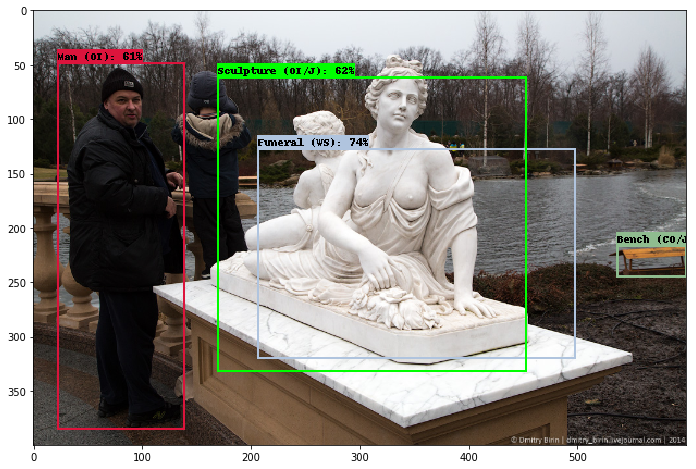

IC0011Y3J.jpg.ldcc


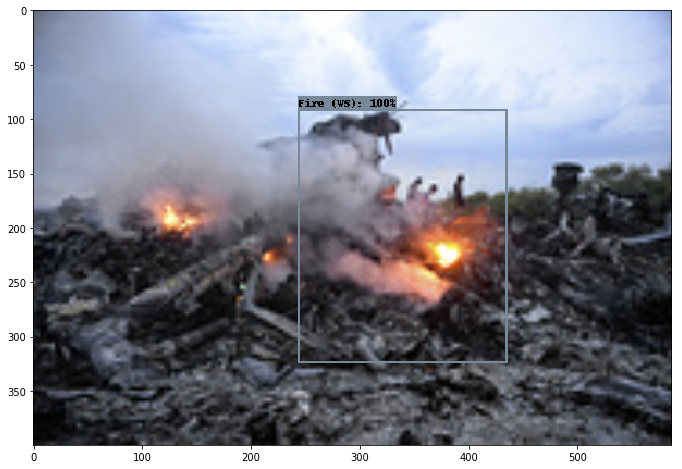

IC0011VCA.jpg.ldcc


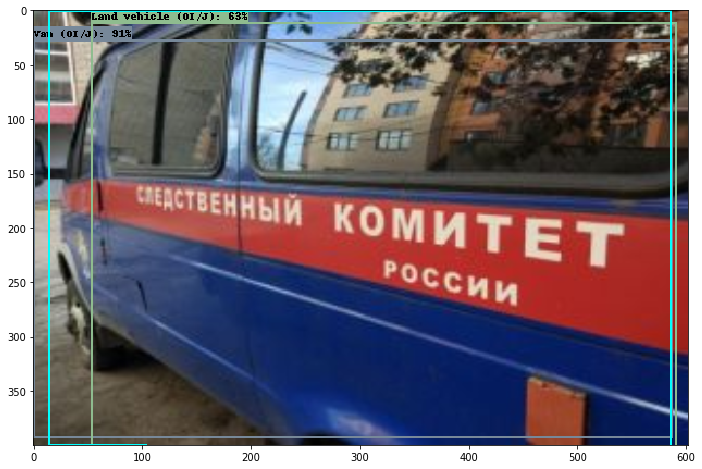

IC0011WJ8.jpg.ldcc


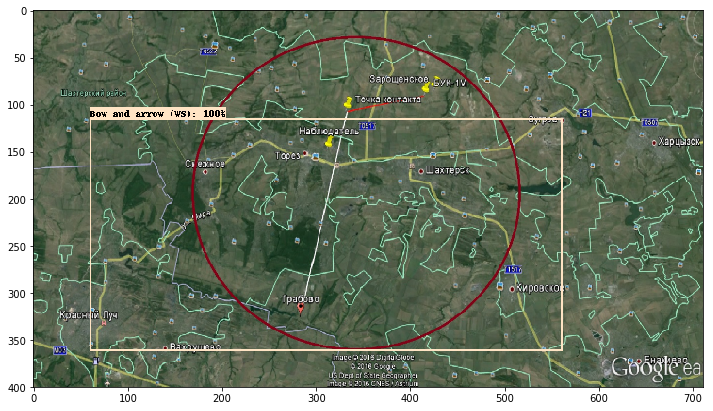

IC0011WJV.jpg.ldcc


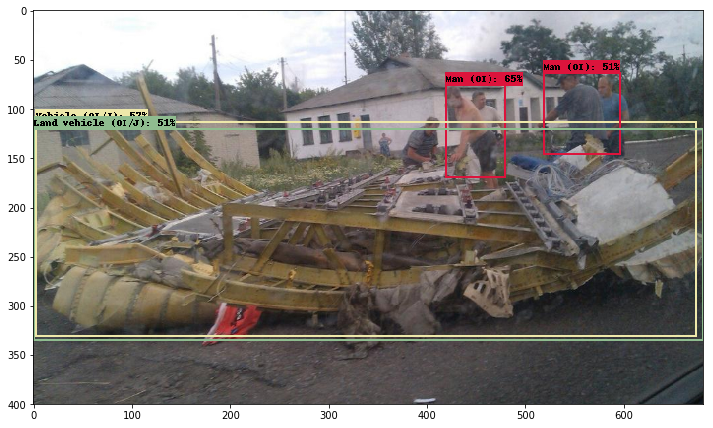

IC0011VC3.jpg.ldcc


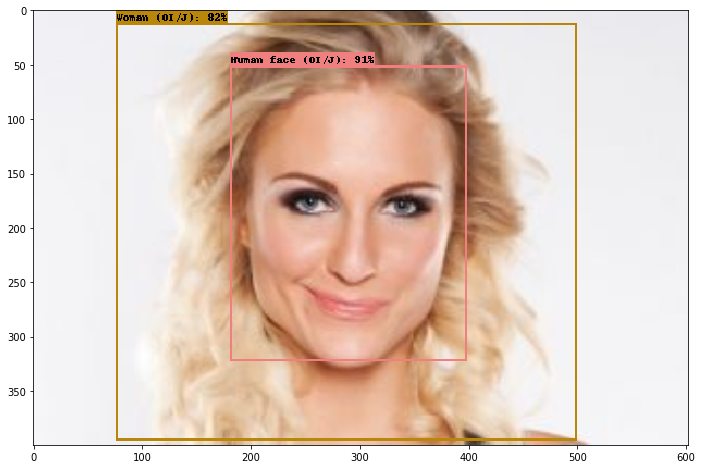

IC0011TN4.jpg.ldcc


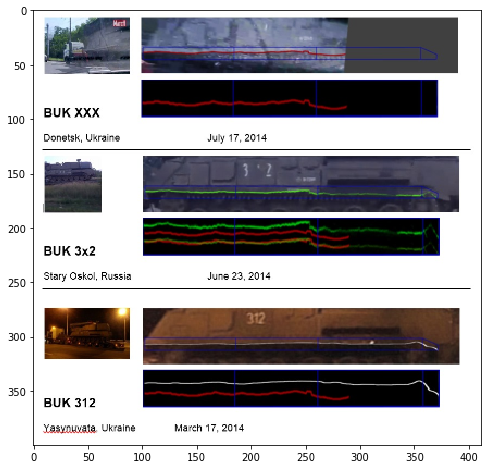

IC0011U7I.jpg.ldcc


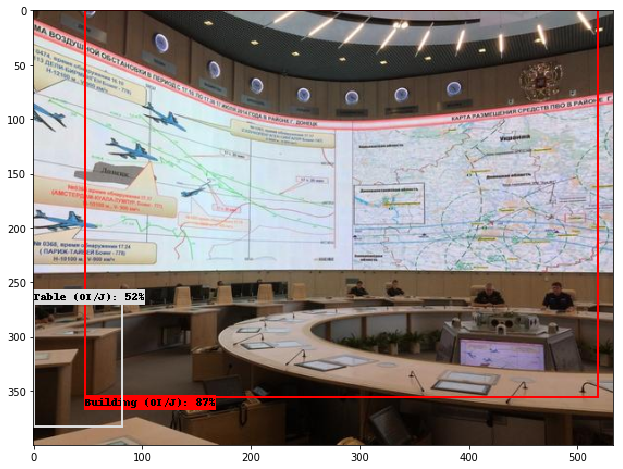

IC0011TA4.jpg.ldcc


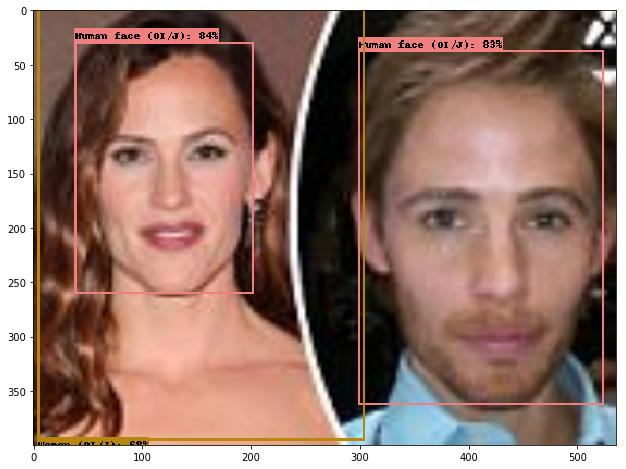

HC000SOOJ.jpg.ldcc


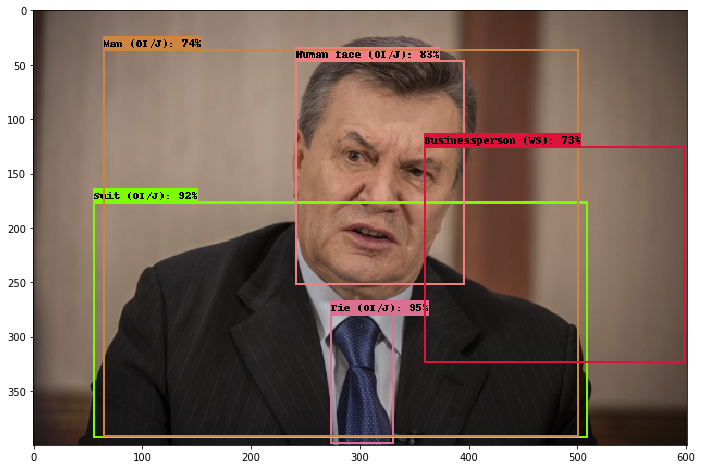

In [51]:
for _ in range(10):
    imgid = np.random.choice(list(det_results_forviz.keys()))
    filename = '../../../data/seedling/jpg/' + imgid
    print(imgid)
    with open(filename, 'rb') as fin:
        _ = fin.read(1024)
        imgbin = fin.read()
    imgbgr = cv2.imdecode(np.fromstring(imgbin, dtype='uint8'), cv2.IMREAD_COLOR)
    image_np = imgbgr[:,:,[2,1,0]]
    image_np = preproc(image_np)
    vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      np.asarray(det_results_forviz[imgid]['detection_boxes']),
      det_results_forviz[imgid]['detection_classes'],
      det_results_forviz[imgid]['detection_scores'],
      category_index_extended,
      instance_masks=det_results_forviz[imgid].get('detection_masks'),
      use_normalized_coordinates=True,
      min_score_thresh=0.5,
      line_thickness=2)
    plt.figure(figsize=(12, 8))
    plt.imshow(image_np)
    plt.show()